# Challenge T2 - Group 19

Content:
1. Text stemming
2. Clustering and interpretation
3. Classification and prediction

### Installation of packages if needed.

In [ ]:
!pip3 install nltk

In [116]:
import nltk
import warnings
warnings.filterwarnings('ignore')
# nltk.download("stopwords")
# nltk.download('punkt')

### Defination of the functions needed for stop words and tokenization.

In [188]:
"""
It takes one or two hours to finish the clustering with all the data,
if you want to test the code,
just take like the first 3000 or so ones.
"""

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import FrenchStemmer
import string
import stop_words
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

"""
To use the two packages of nltk, do 
nltk.download("stopwords")
and
nltk.download('punkt')
in the python console
after you've installed nltk
if you don't want certain word that appears but not filtered by me,
add it in the list ['', '’', '``', '\'\'', '»', '...','«', 'nan', '--']
in the 3rd line of the get_stop_words() function
"""

def get_stop_words():
    stemmer = FrenchStemmer()
    custom_stop_words = set(stopwords.words('french') +
                            list(string.punctuation) +
                            ['', '’', '``', '\'\'', '»', '...','«',
                             'nan', '--', 
                            'an', 'auss', 'autr',
                             'cas', 'cel', 'certain', 'chaqu', 'chos', 'comm',
                             'dan', 'don', 'entre', 
                             'faut', 'franc', 'mettr', 'moin', 'mêm',
                             'non', 'notr', 'oui', 'plus', 
                             'sais', 'san', 'seul', "",
                             'élus', 'polit', 'pay', 'respect', 'citoyen', 'vot', 'part', 'référendum',
                             'compt', 'commum', 'mair', 'bien', 'vi', 'aid',
                             'travail', 'associ', 'exempl',
                             'national', 'blanc', 'élect'
                            ] +
                            stop_words.get_stop_words('fr'))
    custom_stop_words = [stemmer.stem(word) for word in custom_stop_words]
    return custom_stop_words


def tokenize(text):
    stemmer = FrenchStemmer()
    words_temp = word_tokenize(text, language='french')
    words_no_prefix = [f[2:] if f.startswith(("l\'","d\'","j\'","n\'","c\'")) else f for f in words_temp]
    words_no_prefix = [f[3:] if f.startswith(("qu\'")) else f for f in words_no_prefix]
    words_prefect = [stemmer.stem(word) for word in words_no_prefix if not word.isdigit()]
    return words_prefect

## I. Stemming

In [118]:
# choose the file
file_names = ["DEMOCRATIE_ET_CITOYENNETE.csv", "LA_FISCALITE_ET_LES_DEPENSES_PUBLIQUES.csv",
            "LA_TRANSITION_ECOLOGIQUE.csv", "ORGANISATION_DE_LETAT_ET_DES_SERVICES_PUBLICS.csv"]
file_name = file_names[0] # name of the file

We have two ways to get training data, either to load the matrix from the file already preprocessed, or to load the original data and do the preprocessing.

### Method 1: Load the data from `csv` and preprocessing

In [119]:
import random
df = pd.read_csv("data02/" + file_name, low_memory=False)
n_questions= df.shape[1] - 11 # 11 features are basic information
n_answers = df.shape[0]

#Use this of you only want to do one certain question

'''
answers = df["QUXVlc3Rpb246MTA3 - En qui faites-vous le plus confiance pour vous faire représenter dans la société et pourquoi ?"]
answers = answers.str.lower()
answers = answers.values.tolist()
answers = [x for x in answers if type(x) is str]
'''

#Use this if you want to combine the responses of all the questions
answers = df.iloc[:,11:]
answers = answers.astype(str)
answers = answers.apply(" ".join, axis =1)
answers = answers.str.lower()
answers = answers.values.tolist()
answers = random.sample(answers, k = 3000)

In [189]:
#Vectorize our text
custom_stop_words = get_stop_words()
vectorizer = TfidfVectorizer(stop_words=custom_stop_words,
                            tokenizer=tokenize,
                            max_features=100)

In [190]:
'''
The X in the next line is the matrix transformed from all the text data,
if you wants to split the data to train/text or just divide,
split the X
'''

X = vectorizer.fit_transform(answers)
words = vectorizer.get_feature_names()

### Method 2: Load preprocessed matrix

In [191]:
from scipy.sparse import csr_matrix

def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

save_sparse_csr(file_name[:-4] + '-5.npz', X)

In [23]:
X = load_sparse_csr(file_name[:-4] + '.npz')

## II. Clustering

### Part 1: Training and cluster centers

In [192]:
# number of clusters
k = 8

#train the cluster
kmeans = KMeans(n_clusters=k, n_init=10, verbose=1, n_jobs=-1)
kmeans.fit(X)

#Display the clustering results
common_words = kmeans.cluster_centers_.argsort()[:, -1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : immigr, polit, proportionnel, français, écol, integr, économ, déput, public, social, lois, accueil, supprim, limit, sanction, commun, éduc, societ, contr, représent, nombr, grand, oblig, obligatoir, besoin
1 : loi, appliqu, lois, républ, supprim, déput, français, proportionnel, doivent, rien, polit, éduc, plac, commun, mandat, écol, associ, immigr, déjà, nombr, obligatoir, regl, sanction, pouvoir, égal
2 : enfant, écol, éduc, jeun, accueil, associ, polit, chacun, social, commun, grand, plac, temp, oblig, particip, civiqu, comport, import, différent, mieux, doivent, cour, immigr, gen, societ
3 : candidat, pouvoir, rien, social, égal, parl, particip, fonction, propos, supprim, représent, démocrat, import, contr, limit, grand, élu, commun, pris, migr, français, doivent, plac, beaucoup, problem
4 : polit, local, associ, commun, social, représent, niveau, particip, public, éduc, grand, pouvoir, societ, collect, débat, démocrat, doivent, mandat, fonction, publiqu, plac, rôl, organis, déc

In [193]:
# find commum words in clusters
words_freq = {}
for num, centroid in enumerate(common_words):
    for word in centroid:
        words_freq.setdefault(words[word], 0)
        words_freq[words[word]] += 1
sorted_freq = sorted(words_freq.items(), key=lambda kv: kv[1])
print(sorted_freq)

[('économ', 1), ('besoin', 1), ('loi', 1), ('appliqu', 1), ('républ', 1), ('regl', 1), ('enfant', 1), ('jeun', 1), ('chacun', 1), ('comport', 1), ('différent', 1), ('mieux', 1), ('cour', 1), ('propos', 1), ('pris', 1), ('migr', 1), ('niveau', 1), ('collect', 1), ('débat', 1), ('rôl', 1), ('décis', 1), ('action', 1), ('servic', 1), ('intérêt', 1), ('général', 1), ('consult', 1), ('assembl', 1), ('sénat', 1), ('sénateur', 1), ('sort', 1), ('peupl', 1), ('pens', 1), ('question', 1), ('faudr', 1), ('mond', 1), ('vrai', 1), ('demand', 1), ('prendr', 1), ('voir', 1), ('integr', 2), ('lois', 2), ('accueil', 2), ('oblig', 2), ('déjà', 2), ('égal', 2), ('civiqu', 2), ('import', 2), ('gen', 2), ('candidat', 2), ('parl', 2), ('démocrat', 2), ('élu', 2), ('beaucoup', 2), ('problem', 2), ('publiqu', 2), ('organis', 2), ('rendr', 2), ('conseil', 2), ('immigr', 3), ('français', 3), ('public', 3), ('limit', 3), ('sanction', 3), ('contr', 3), ('nombr', 3), ('rien', 3), ('mandat', 3), ('temp', 3), ('loc

### Part 2: Word Clouds Generation

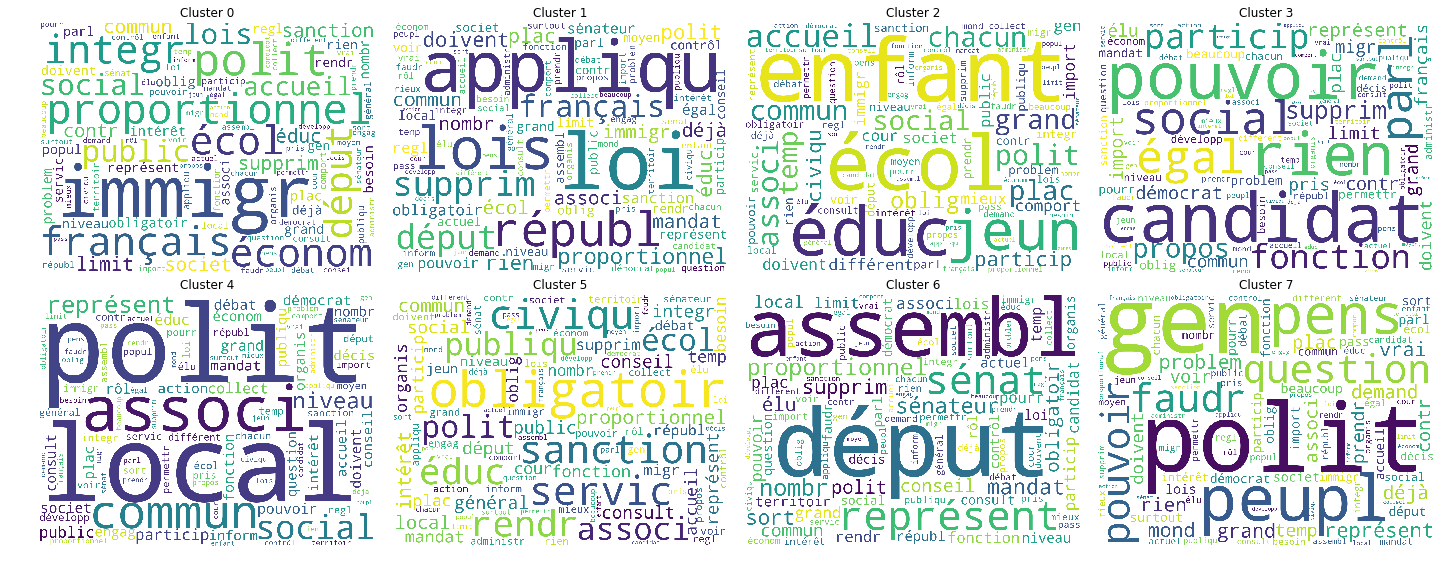

In [194]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

wcs = []
for center in kmeans.cluster_centers_:
    wc = WordCloud(width=1600, height=1200, background_color="white")
    dictionary = dict(zip(words, center))
    wcs.append(wc.generate_from_frequencies(dictionary))

plt.figure(figsize=(25, 10))
for i in range (0, 8):
    ax = plt.subplot(2,4,i+1)
    ax.imshow(wcs[i])
    ax.axis("off")
    ax.set_title("Cluster "+str(i))
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()

In [195]:
# save and load the model
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
joblib.dump(kmeans, 'kmeans_8_clusters-5.pkl')

['kmeans_8_clusters-5.pkl']

In [37]:
# Load the model from the file 
knn_from_joblib = joblib.load('kmeans_8_clusters.pkl')  
  
# Use the loaded model to make predictions 
# knn_from_joblib.predict(X_test)

In [38]:
def get_answer(query, words):
    # for an entry, combine its key words
#     query_list = query.copy()
#     query_list.sort()
    return ','.join([words[i] for i in range(len(query)) if query[i] > 0])

In [27]:
#get_answer(X.toarray()[0], words)

### Part 3: Distribution and cluster assignments

In [196]:
y = kmeans.labels_ 

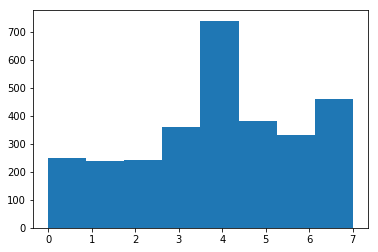

In [197]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(y, bins=8)
plt.show()

In [127]:
# dictionary of clusters as keys and answers as values
cluster_assignments_dict = {}

for i in set(y):
#     print("Cluster ", i)
    X_array = X.toarray()
    current_cluster_answers = [get_answer(X_array[x], words) for x in np.where(y == i)[0]]
    cluster_assignments_dict[i] = current_cluster_answers

In [129]:
# show one cluster
cluster_pick = np.random.choice(len(set(y)))
print(f'Cluster {cluster_pick}')
cluster_assignments_dict[cluster_pick]

Cluster 1


['actuel,aid,appliqu,assembl,bien,blanc,citoyen,compt,contr,cour,différent,déput,exempl,fonction,immigr,integr,intérêt,limit,loi,lois,mair,mandat,mieux,mond,national,niveau,oblig,obligatoir,part,pay,pens,plac,polit,pourr,pouvoir,pris,proportionnel,public,publiqu,question,représent,respect,rien,rôl,social,sort,supprim,temp,travail,vi,voir,vot,vrai,écol,économ,éduc,élect,élus',
 'accueil,aid,appliqu,associ,besoin,blanc,citoyen,commun,doivent,débat,déjà,déput,engag,exempl,grand,loi,mond,oblig,obligatoir,organis,part,pay,polit,pourr,question,rendr,rien,rôl,sanction,sénateur,vot,vrai,écol,élect',
 'bien,blanc,compt,consult,doivent,décis,déput,exempl,fonction,grand,immigr,integr,limit,local,moyen,national,niveau,obligatoir,plac,pourr,pouvoir,proportionnel,public,question,regl,rendr,référendum,societ,vi,vot,vrai,économ,élect',
 'appliqu,blanc,citoyen,contr,démocrat,déput,enfant,immigr,limit,lois,mond,nombr,obligatoir,pay,plac,question,rendr,respect,rien,républ,supprim,sénat,sénateur,travail,v

### Part 4: Visualization with t-SNE

Still, we can apply the algorithm or load the transformed data from the file

In [198]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
X_reduced = TruncatedSVD(n_components=8, random_state=0).fit_transform(X)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.040s...
[t-SNE] Computed neighbors for 3000 samples in 1.411s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.994s
[t-SNE] Iteration 50: error = 78.8491898, gradient norm = 0.0233581 (50 iterations in 9.529s)
[t-SNE] Iteration 100: error = 78.3289261, gradient norm = 0.0000994 (50 iterations in 6.828s)
[t-SNE] Iteration 150: error = 78.3271561, gradient norm = 0.0000361 (50 iterations in 4.346s)
[t-SNE] Iteration 200: error = 78.3271255, gradient norm = 0.0000172 (50 iterations in 4.310s)
[t-SNE] Iteration 250: error = 78.3271332, gradient norm = 0.0000251 (50 iterations in 4.088s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.327133
[t-SNE] Iteration 300: err

In [200]:
np.save("X_embedded.npy", X_embedded)
# X_embedded = np.load("X_embedded.npy")

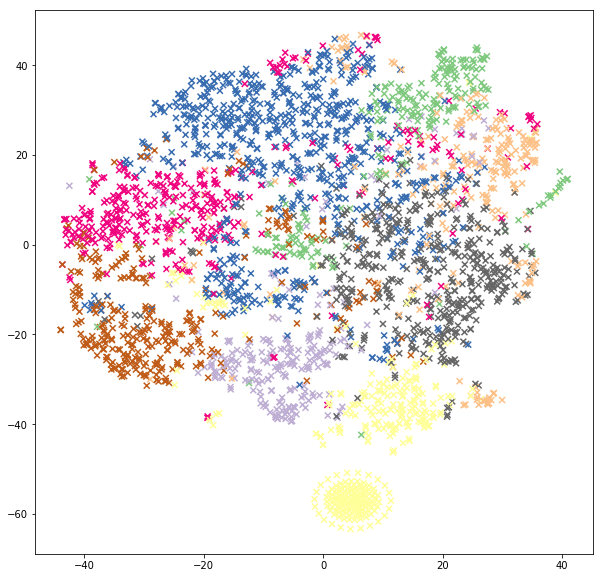

In [199]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker = "x", c = y, cmap="Accent")
plt.show()

In [47]:
# not necessary for classification
# labels from clustering
# transform labels to onehot code

# from sklearn.preprocessing import OneHotEncoder
# cat_encoder = OneHotEncoder()
# y_1hot = cat_encoder.fit_transform(y.reshape(-1,1))

## III. Classification

In [148]:
# split into training set and test set
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

y = kmeans.labels_
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)

In [151]:
'''
Random Forest Classifier
'''
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
cv = cross_val_score(clf, X, y, cv=10)
print("Best performance of Random Forests: ", np.max(cv))

Best performance of Random Forests:  0.825503355704698


In [153]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7716666666666666

In [150]:
from sklearn.ensemble import ExtraTreesClassifier
clf_extra = ExtraTreesClassifier(n_estimators=100)
# clf.fit(X_train, y_train)
cv = cross_val_score(clf_extra, X, y, cv=10)
print("Best performance of Extra Trees: ", np.max(cv))

Best performance of Extra Trees:  0.8221476510067114


In [154]:
'''
haven't tried this
train report
'''
from sklearn import metrics

y_predicted = clf.predict(X)
print(metrics.classification_report(y, y_predicted))

#TODO
#Use the STEP1 cluster and the STEP2 cluster to predict the same
#block of data, use the result of the cluster as the correct one
#track the performance. Or you can change the parameters as you wish

#TODO IMPORTANT
#observe the clustering result and try to find a meaningful representation
#of each cluster like "people with a negative view", "people who don't believe
# democracy", etc. Like this our report will be more meaningful.

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       292
           1       0.98      0.95      0.96       250
           2       0.97      0.94      0.95       437
           3       0.97      0.95      0.96       416
           4       0.97      0.99      0.98       232
           5       0.98      0.99      0.98       361
           6       0.94      0.92      0.93       434
           7       0.92      0.97      0.94       578

   micro avg       0.95      0.95      0.95      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.95      0.95      0.95      3000

